[View in Colaboratory](https://colab.research.google.com/github/erconui/cs501r/blob/master/first_dll.ipynb)

In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import pdb
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm

assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

In [10]:
class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
               padding=0, dilation=1, groups=1, bias=True):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()
    
    self.weight = Parameter(torch.Tensor(out_channels, in_channels,
                                         *kernel_size))
    
    self.bias = Parameter(torch.Tensor(out_channels))
    
#     ## Uniform Initialization
#     self.weight.data.uniform_(-1,1)
#     self.bias.data.uniform_(0,0)
    ## XE Initialization
#     self.weight.data.fill_(0.01)
#     self.bias.data.fill_(0.01)
    ## Orthogonal Initialization
    width = in_channels*kernel_size[0]*kernel_size[1]
    X = np.random.random((out_channels, width))
    U, _, VT = np.linalg.svd(X,full_matrices=False)
    if out_channels > width:
      weight = U
    else:
      weight = VT
    weight = weight.reshape((out_channels, in_channels, kernel_size[0], kernel_size[1]))
    self.weight = Parameter(torch.tensor(weight).float())
      # do it in numpy, bring in numpy orthogonal weight matrix
    
    
    
  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding,
                    self.dilation, self.groups)
  
  def extra_repr(self):
    return '501r is so cool'

class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100,reduce=None, reduction='elementwise_mean'):
    super(CrossEntropyLoss, self).__init__()
    
  def forward(self, x, labels):
    alpha = 0 # torch.max(x)
    softmax = -torch.log(torch.exp(x-alpha)/torch.exp(x-alpha).sum(1, keepdim=True))
    r = torch.arange(softmax.size(0))
    return softmax[r, labels].mean()
  
class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c,h,w = x.size()
    output = 10
    
    self.net = nn.Sequential(
      Conv2d(c, 100, (3,3), padding=(1,1)),
      nn.ReLU(),
      Conv2d(100, output, (28,28), padding=(0,0))
    )
   
  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)

class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(
        root, train=train, transform=transforms.ToTensor(), download=True)
#     self.e = torch.eye(10)
    
  def __getitem__(self, i):
    x, y = self.data[i]
#     pdb.set_trace()
    return x, y
#     return x, self.e[y].float()
  
  def __len__(self):
    return len(self.data)

loss:212393616102147005869981696.0000: 100%|██████████| 1429/1429 [01:36<00:00, 14.88it/s]


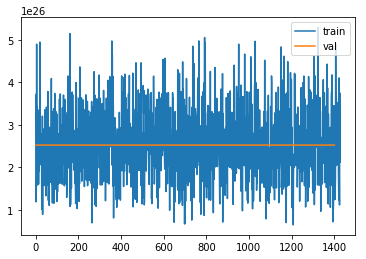

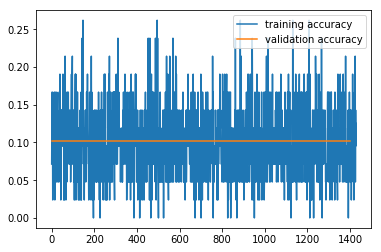

In [11]:
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

model = ConvNetwork(train_dataset)
model.cuda()
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=42, pin_memory=True)

losses = []
validations = []
accuracies = []
val_accuracies = []
for epoch in range(1):
  loop = tqdm(total=len(train_loader), position=0)
  for batch, (x, y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    
    optimizer.zero_grad()
    y_hat = model(x)
    
    loss = objective(y_hat,y_truth)
    
    loss.backward()
    
    losses.append(loss)
    accuracy = (torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean()
    accuracies.append(accuracy)
    loop.set_description('loss:{:.4f}'.format(loss.item()))
    loop.update(1)

    optimizer.step()
    
    if batch % 50 == 0:
      vals = []
      tmp_accuracies = []
      for x1,y in val_loader:
        x1, y_truth1 = x1.cuda(async=True), y.cuda(async=True)
        y_hat = model(x1)
        tmp = objective(y_hat, y_truth1).item()
        vals.append(tmp)
        accuracy = (y_hat.argmax(1) == y_truth1).float().mean()
        tmp_accuracies.append(accuracy)
                    
      val_accuracies.append((len(losses), np.mean(tmp_accuracies)))
      validations.append((len(losses), np.mean(vals)))

  loop.close()

a, b = zip(*validations)
# fig, ax = plt.subplots(1,2)
plt.plot(losses, label='train')
plt.plot(a, b, label='val')
plt.legend()
plt.show()
plt.plot(accuracies, label='training accuracy')
a, b = zip(*val_accuracies)
plt.plot(a, b, label="validation accuracy")
plt.legend()
plt.show()

In [5]:
## Cross Entropy loss
# check it outputs the same as pytorch's crossentropyloss

#necessary for the soft max
a = torch.from_numpy(np.random.randn(3,4,1).astype(np.float32))
b = torch.exp(a)
z = a / b.sum(1, keepdim=True)

# Part 4
## Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)

 (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3,3), padding=())

(c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=, kernel_size=(), padding=())

(c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=, kernel_size=(), padding=())

## Using a Kernel size of 5×5:

 (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=, kernel_size=(), padding=())

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=, kernel_size=(), padding=())

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=, kernel_size=(), padding=())

## Using Kernel size of 5×3:

 (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=, kernel_size=(), padding=())

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=, kernel_size=(), padding=())

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=, kernel_size=(), padding=())

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=, kernel_size=(), padding=())

## Determine the kernel that requires the smallest padding size to make the following mappings possible:

 (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=, kernel_size=(), padding=())

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=, kernel_size=(), padding=())